#**Ejemplo de Arbol de Decisión con Python**

Para empezar importemos las librerías que utilizaremos y revisemos los atributos de entrada del dataset a usar. Si hace falta se instalan los módulos necesarios.

In [ ]:
#!pip install -U seaborn

In [ ]:
# Imports needed for the script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

A partir de atributos de cantantes y de un histórico de canciones que alcanzaron entrar al Billboard 100 (U.S.) en 2013 y 2014 crearemos un árbol que nos permita intentar predecir si un nuevo cantante podrá llegar a número uno.

In [ ]:
url3='https://raw.githubusercontent.com/albreyes/python/main/Grupo%20de%20python/databases/artists_billboard_fix3.csv'


Ahora veamos cuantas columnas y registros tenemos:

In [ ]:
artists_billboard=pd.read_csv(url3)
#artists_billboard

In [ ]:
artists_billboard.shape

(635, 11)

Esto nos devuelve (635,11) es decir que tenemos 11 columnas (features) y 635 filas de datos. Vamos a echar un ojo a los primeros registros para tener una mejor idea del contenido:

In [ ]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


Vemos que tenemos: Titulo de la canción, artista, “mood” ó estado de ánimo de esa canción, tempo, género, Tipo de artista, fecha en que apareció en el billboard (por ejemplo 20140628 equivale al 28 de junio de 2014), la columna TOP será nuestra etiqueta, en la que aparece 1 si llegó al número uno de Billboard ó 0 si no lo alcanzó y el anio de Nacimiento del artista. Vemos que muchas de las columnas contienen información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que nos convendrá pasar a categórico más adelante.

Vamos a realizar algunas visualizaciones para comprender mejor nuestros datos.

Primero, agrupemos registros para ver cuántos alcanzaron el número uno y cuantos no:

In [ ]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

Es decir que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad DESBALANCEADA de etiquetas con 1 y 0. Lo tendremos en cuenta al momento de crear el árbol.

<Axes: xlabel='top', ylabel='count'>

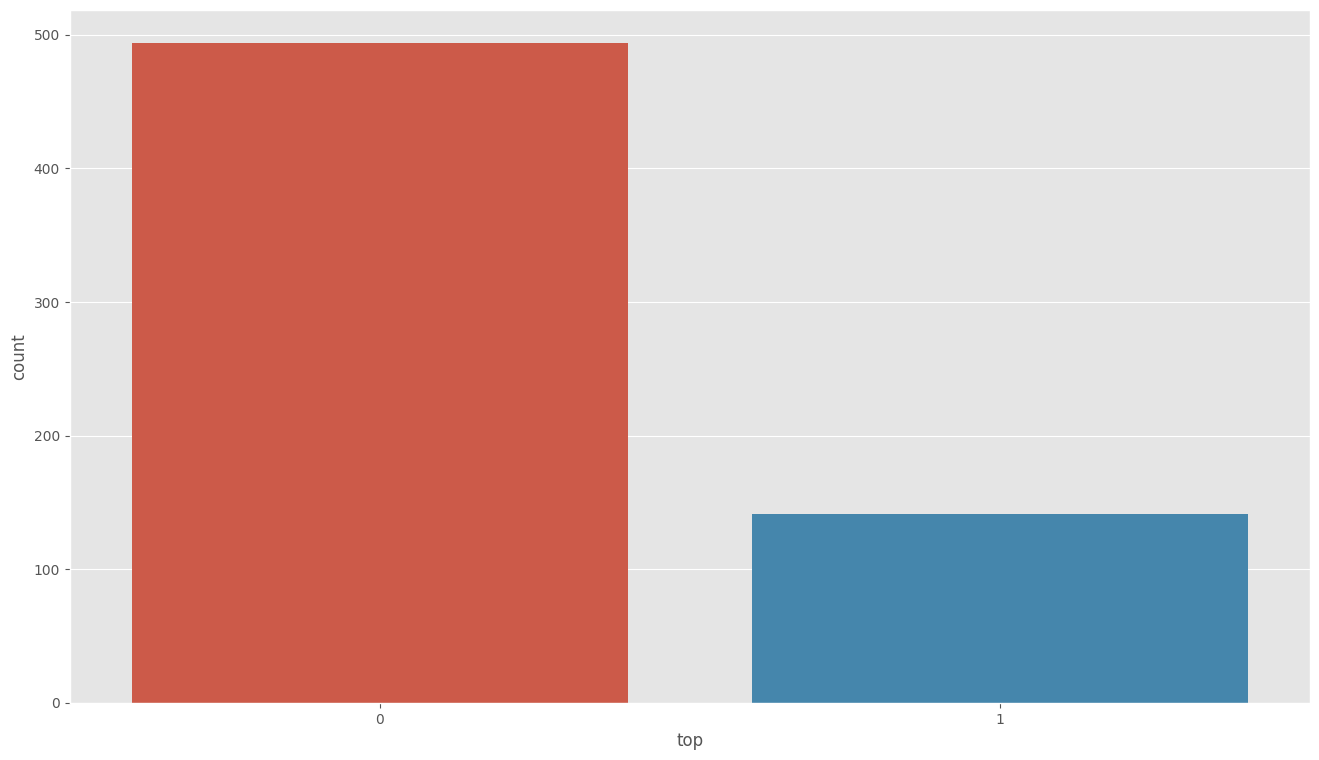

In [ ]:
sb.countplot(x='top',data=artists_billboard)

Veamos cuántos registros hay de tipo de artista, “mood”, tempo y género de las canciones:

<Axes: xlabel='artist_type', ylabel='count'>

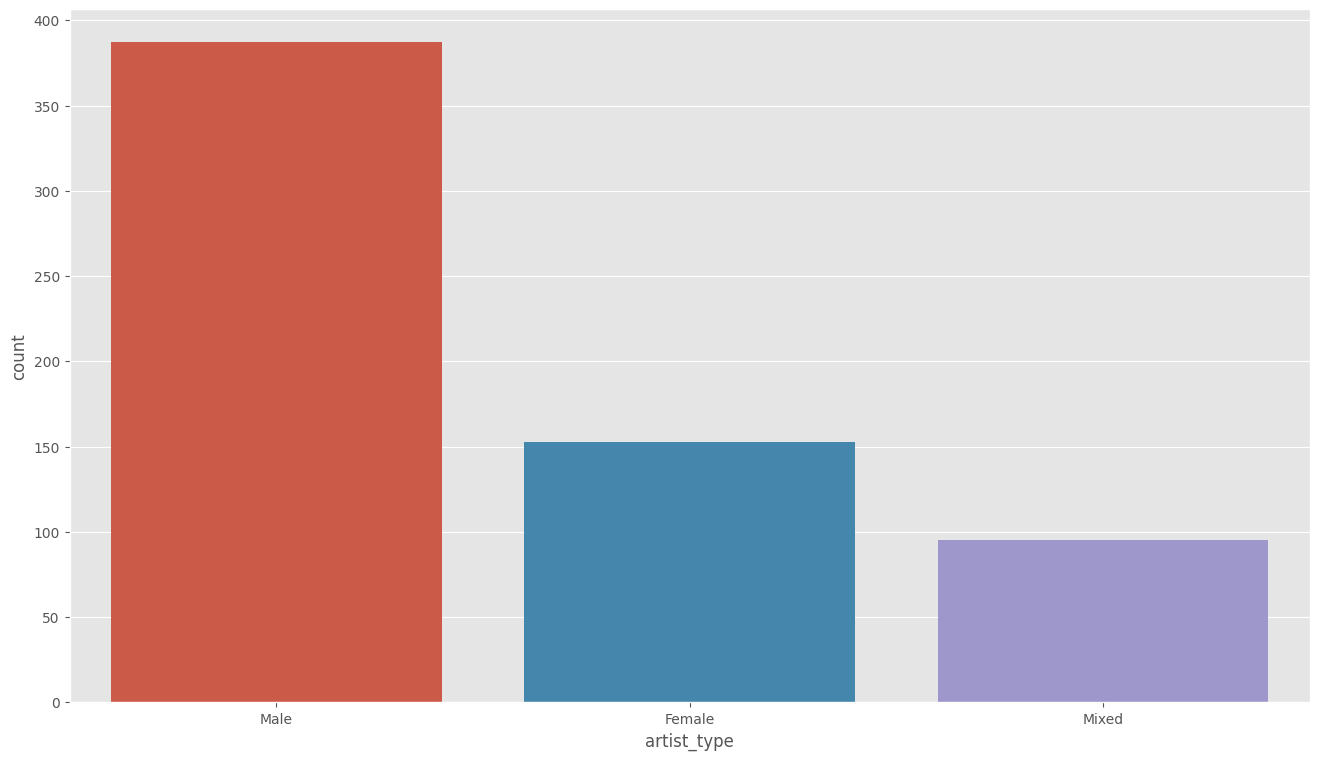

In [ ]:
sb.countplot(x='artist_type',data=artists_billboard)

<Axes: xlabel='mood', ylabel='count'>

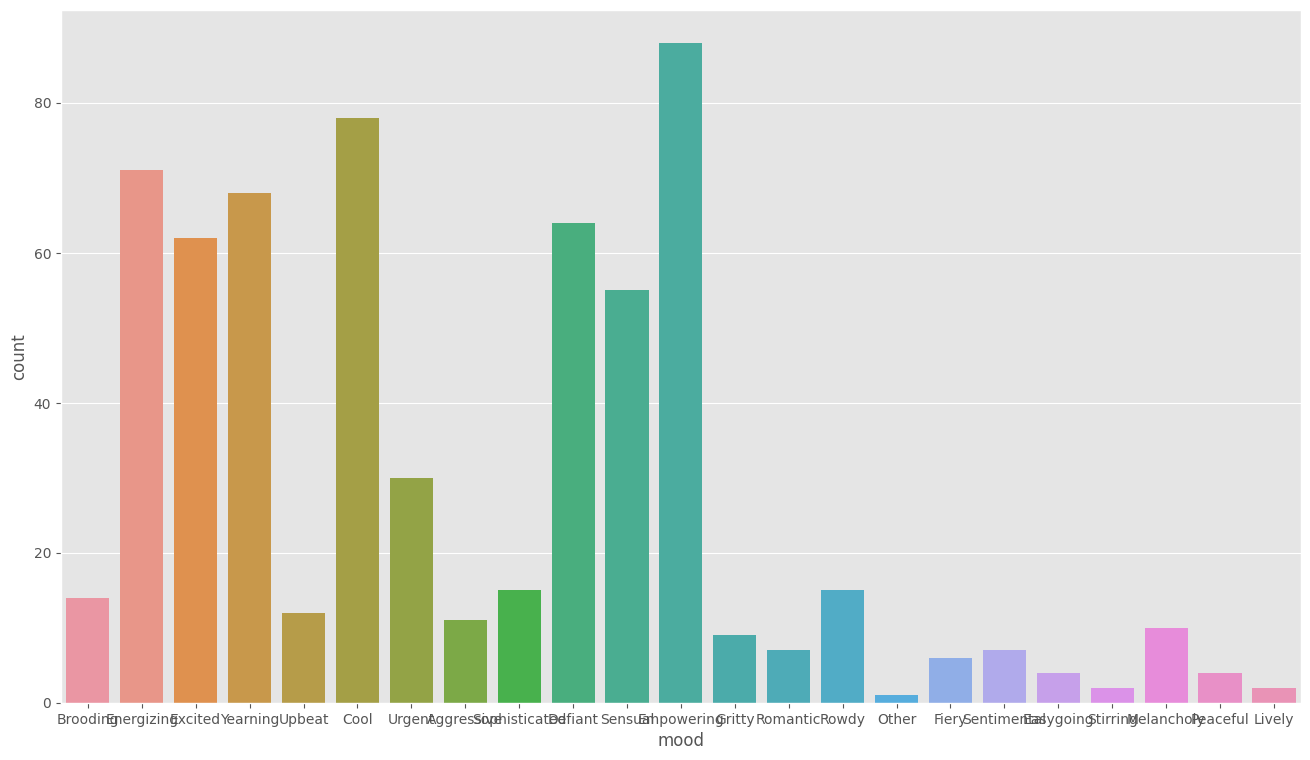

In [ ]:
sb.countplot(x='mood',data=artists_billboard)

<Axes: xlabel='tempo', ylabel='count'>

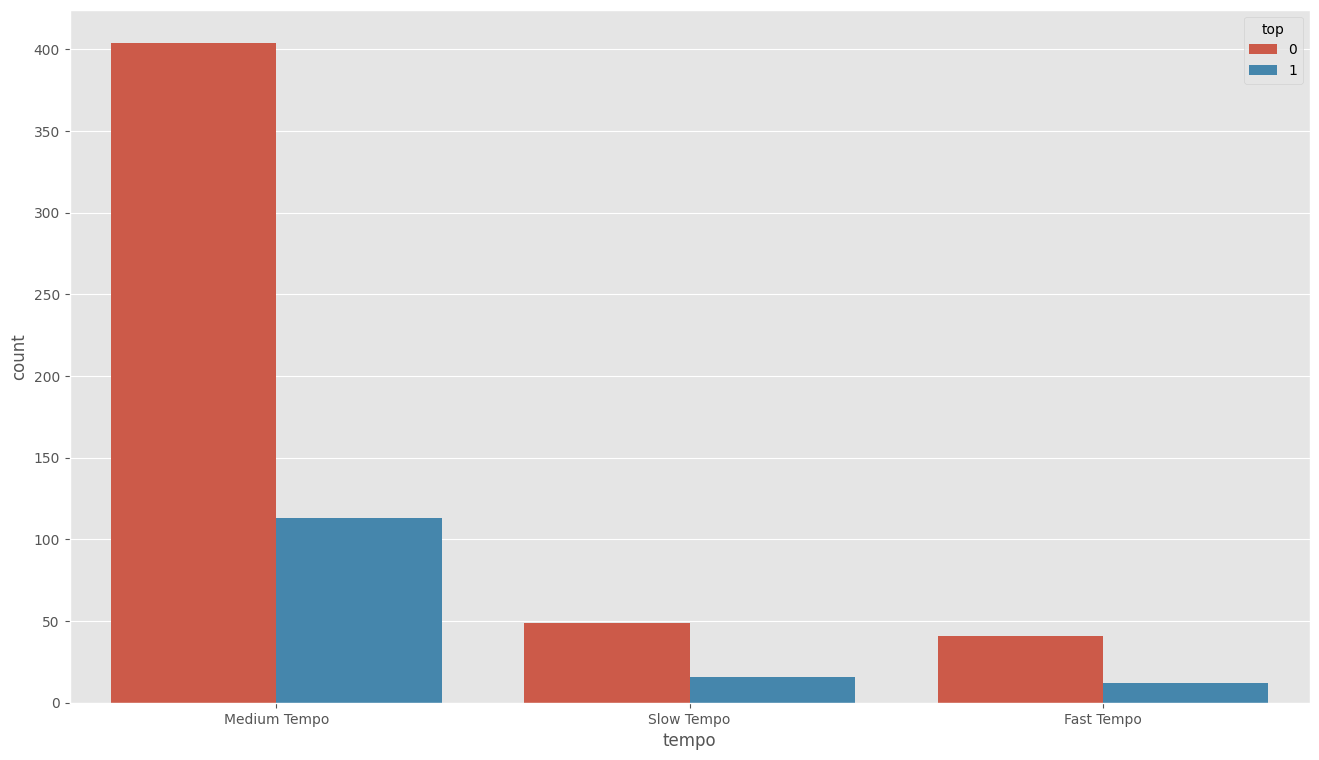

In [ ]:
sb.countplot(x='tempo',data=artists_billboard, hue = 'top')

<Axes: xlabel='genre', ylabel='count'>

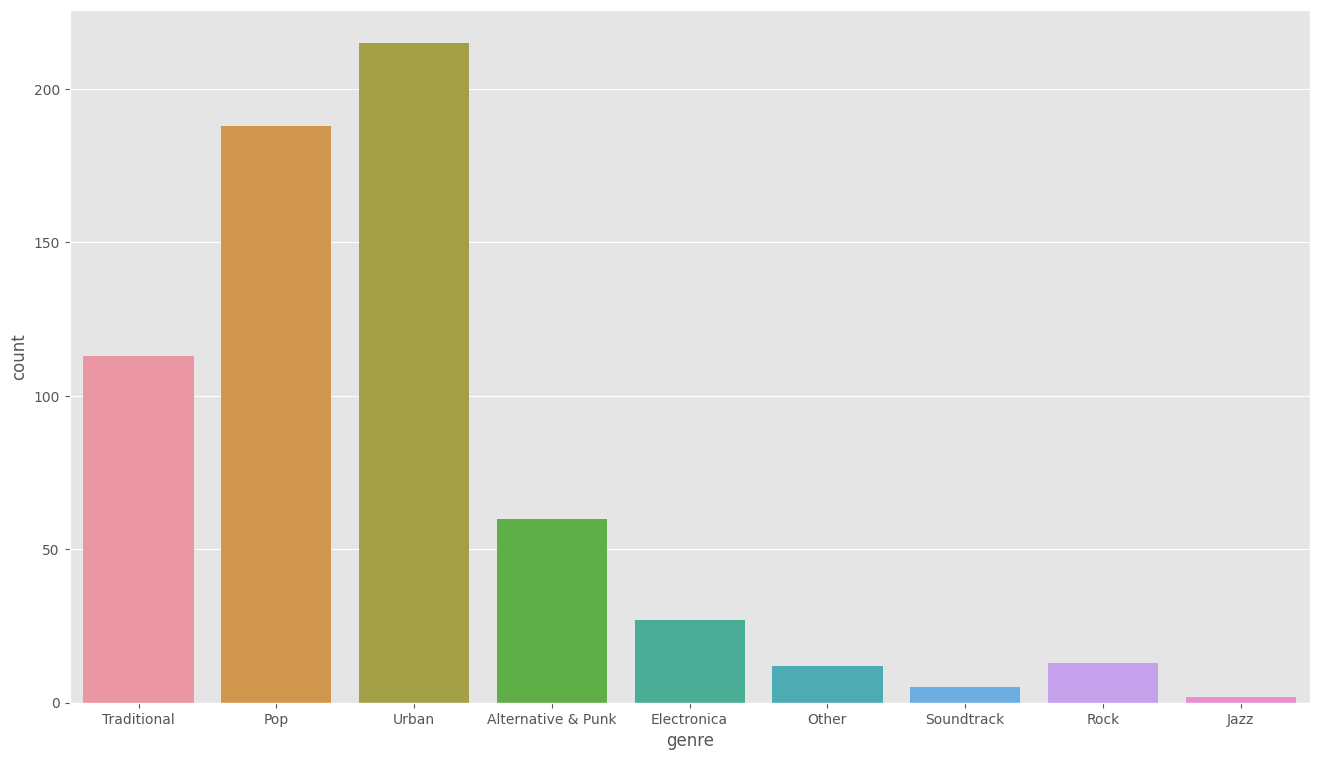

In [ ]:
sb.countplot(x='genre',data=artists_billboard)

Veamos ahora que pasa al visualizar los años de nacimiento de los artistas:

<Axes: xlabel='anioNacimiento', ylabel='count'>

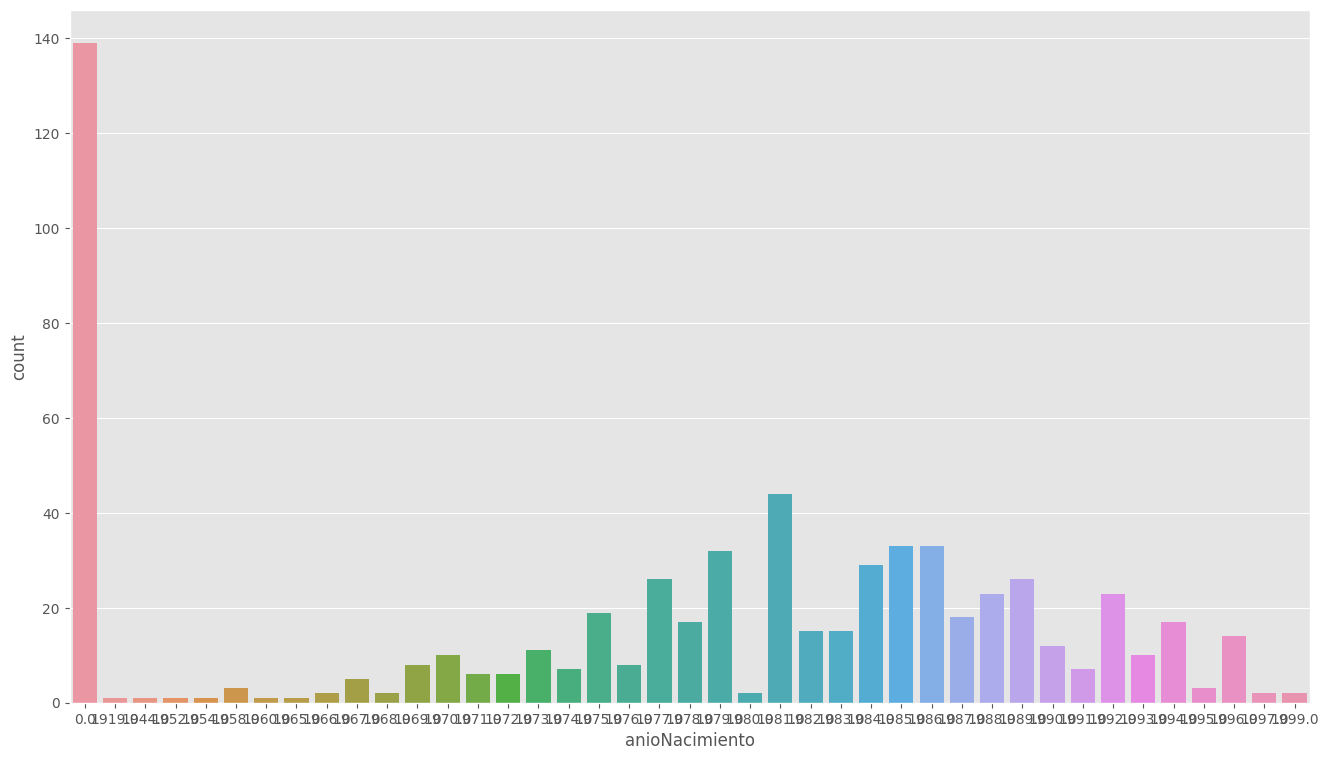

In [ ]:
sb.countplot(x='anioNacimiento',data=artists_billboard)

Como se ve en la gráfica tenemos cerca de 140 canciones de las cuales desconocemos el año de nacimiento del artista. El resto de años parecen concentrarse entre 1979 y 1994 (a ojo). Más adelante trataremos estos registros.

## Balanceo de datos

Una forma de balancear los valores de top (si[141], no[494]), es agregando más  canciones si TOP de años previos. Sin embargo, más tarde utilizaremos un parámetro del algoritmo de árbol de decisión para compensar esta diferencia, el parámetro *class_weight*.


Visualicemos los top y no top de acuerdo a sus fechas en los Charts

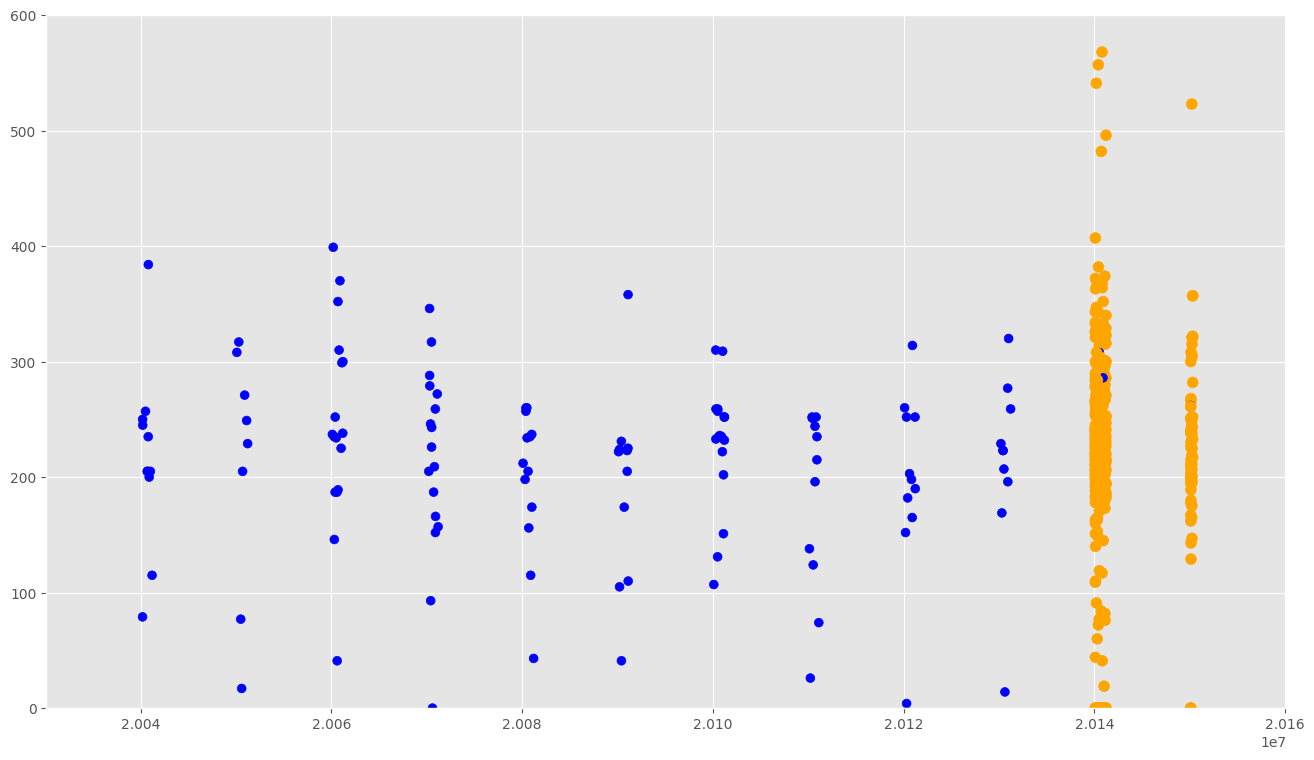

In [ ]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

colores=['orange','blue'] # si no estaban declarados previamente
tamanios=[60,40] # si no estaban declarados previamente

asignar=[]
asignar2=[]
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

#asignar2
#plt.scatter(f1, f2, c=asignar)
plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101,20160101,0,600])
plt.show()

En nuestro conjunto de Datos, se agregaron canciones que llegaron al top (en azul) de años 2004 al 2013 para sumar a los apenas 11 que lo habían logrado en 2014-2015.

## Preparación de los datos

Vamos a arreglar el problema de que hay años de nacimiento que están en cero. Realmente el atributo o característica que queremos obtener es : “sabiendo el año de nacimiento del cantante, calcular qué edad tenía al momento de aparecer en el Billboard”. Por ejemplo un artista que nació en 1982 y apareció en los charts en 2012, tenía 30 años.

Para eso, primero vamos a sustituir los ceros de la columna “anioNacimiento”por el valor None -que es es nulo en Python

In [ ]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

Luego vamos a calcular las edades en una nueva columna “edad_en_billboard” restando el año de aparición (los 4 primeros caracteres de chart_date) al año de nacimiento. En las filas que estaba el año en None, tendremos como resultado edad None.


In [ ]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

Y finalmente asignaremos edades aleatorias a los registros faltantes: para ello, obtenemos el promedio de edad de nuestro conjunto (avg) y su desvío estándar (std) -por eso necesitábamos las edades en None- y pedimos valores random a la función que van desde avg – std hasta avg + std. En nuestro caso son edades de entre 21 a 37 años.

In [ ]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


Si bien lo ideal es contar con la información real, y de hecho la podemos obtener buscando en Wikipedia (o en otras webs de música), quise mostrar otra vía para poder completar datos faltantes manteniendo los promedios de edades que teníamos en nuestro conjunto de datos.

Podemos visualizar los valores que agregamos (en color verde) en el siguiente gráfico:

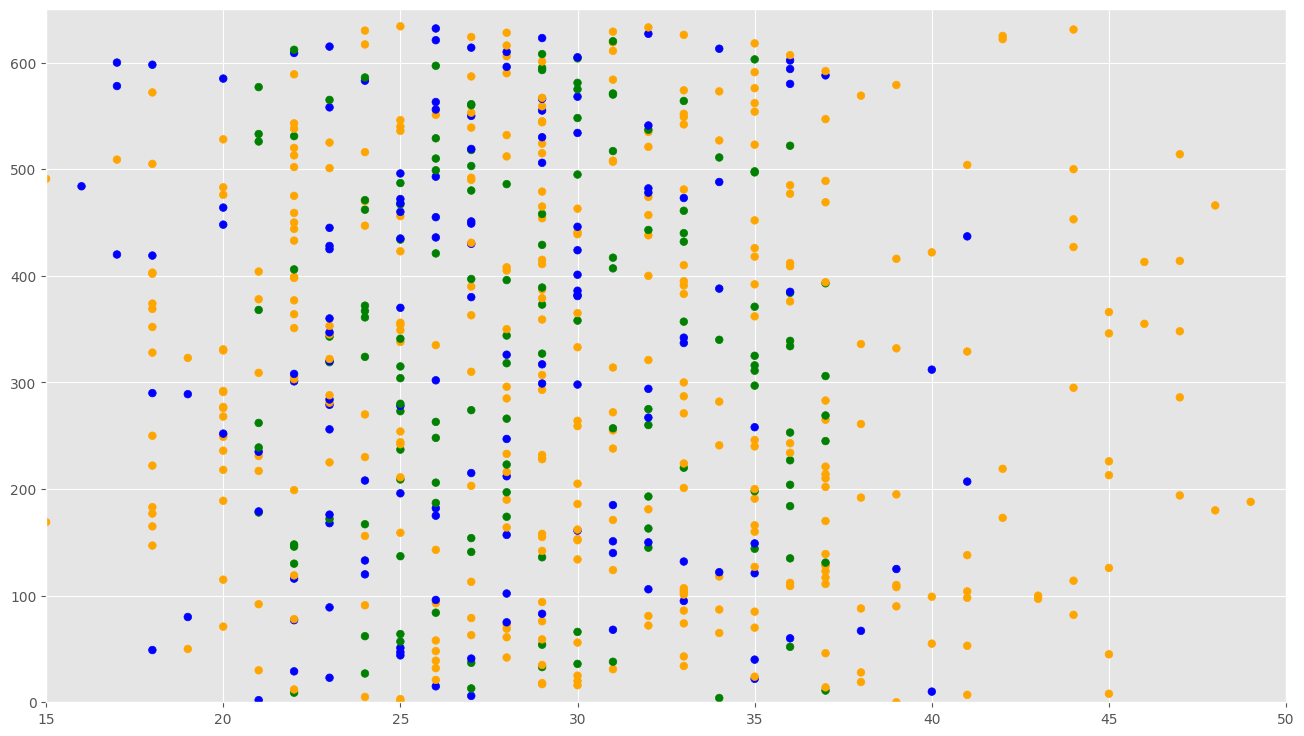

In [ ]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

## Mapeo de datos

Vamos a transformar varios de los datos de entrada en valores categóricos. Las edades, las separamos en: menor de 21 años, entre 21 y 26, etc. las duraciones de canciones también, por ej. entre 150 y 180 segundos, etc. Para los estados de ánimo (mood) agrupé los que eran similares.

El Tempo que puede ser lento, medio o rápido queda mapeado: 0-Rapido, 1-Lento, 2-Medio (por cantidad de canciones en cada tempo: el Medio es el que más tiene)

In [ ]:
# Mood Mapping
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6,
                                        'Empowering': 6,
                                        'Cool': 5,
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3,
                                        'Sensual': 2,
                                        'Gritty': 3, #coraje
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3,
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4,
                                        'Romantic': 2,
                                        'Peaceful': 1,
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4,
                                          'Pop': 3,
                                          'Traditional': 2,
                                          'Alternative & Punk': 1,
                                         'Electronica': 1,
                                          'Rock': 1,
                                          'Soundtrack': 0,
                                          'Jazz': 0,
                                          'Other':0,'':0}
                                       ).astype(int)
# artist_type Mapping
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded']                         = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded']                          = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

Finalmente, obtenemos un nuevo conjunto de datos llamado artists_encoded con el que tenemos los atributos definitivos para crear nuestro árbol. Para ello, quitamos todas las columnas que no necesitamos con “drop”:

In [ ]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

Revisemos en tablas cómo se reparten los top=1 en los diversos atributos mapeados. Sobre la columna sum, estarán los top, pues al ser valor 0 o 1, sólo se sumarán los que sí llegaron al número 1.

In [ ]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

La mayoría de top 1 los vemos en los estados de ánimo 5 y 6 con 46 y 43 canciones

In [ ]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

Aqui están bastante repartidos, pero hay mayoría en tipo 3: artistas masculinos

In [ ]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

Los géneros con mayoría son evidentemente los géneros 3 y 4 que corresponden con Urbano y Pop

In [ ]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

El tempo con más canciones exitosas en el número 1 es el 2, tempo medio

In [ ]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

Están bastante repartidos en relación a la duración de las canciones

In [ ]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.253731    67  17
1.0          0.303797   158  48
2.0          0.246753   154  38
3.0          0.172249   209  36
4.0          0.042553    47   2

Edad con mayoría es la tipo 1 que comprende de 21 a 25 años.

##Buscamos la profundidad para nuestro árbol de decisión

Ya casi tenemos nuestro árbol. Antes de crearlo, vamos a buscar cuántos niveles de profundidad le asignaremos. Para ello, aprovecharemos la función de KFold que nos ayudará a crear varios subgrupos con nuestros datos de entrada para validar y valorar los árboles con diversos niveles de profundidad. De entre ellos, escogeremos el de mejor resultado.

##Creamos el árbol y lo tuneamos

Para crear el árbol utilizamos de la librería de sklearn tree.DecisionTreeClasifier pues buscamos un árbol de clasificación (no de Regresión). Lo configuramos con los parámetros:

*   *criterion*=entropy ó podría ser gini, pero utilizamos entradas categóricas
*   *min_samples_split=20* se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.
*    *min_samples_leaf=5* cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja y “subiría” un nivel, su antecesor.
* *class_weight={1:3.5}* IMPORTANTíSIMO: con esto compensamos los desbalances que hubiera. En nuestro caso, como venía diciendo anteriormente, tenemos menos etiquetas de tipo top=1 (los artistas que llegaron al número 1 del ranking). Por lo tanto, le asignamos 3.5 de peso a la etiqueta 1 para compensar. El valor sale de dividir la cantidad de top=0 (son 494) con los top=1 (son 141).

NOTA: estos valores asignados a los parámetros fueron puestos luego de prueba y error (muchas veces visualizando el árbol, en el siguiente paso y retrocediendo a este).

In [ ]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold]
        f_valid = artists_encoded.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['top'], axis=1),
                               y = f_train["top"])
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1),
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.564038
         4          0.647272
         5          0.620511
         6          0.637748
         7          0.651959


Podemos ver que en 4 niveles de splits tenemos el score más alto, con casi 65%.

##Visualización del árbol

Asignamos los datos de entrada y los parámetros que configuramos anteriormente con 4 niveles de profundidad. Utilizaremos la función de export_graphviz para crear un archivo de extensión .dot que luego convertiremos en un gráfico png para visualizar el árbol.

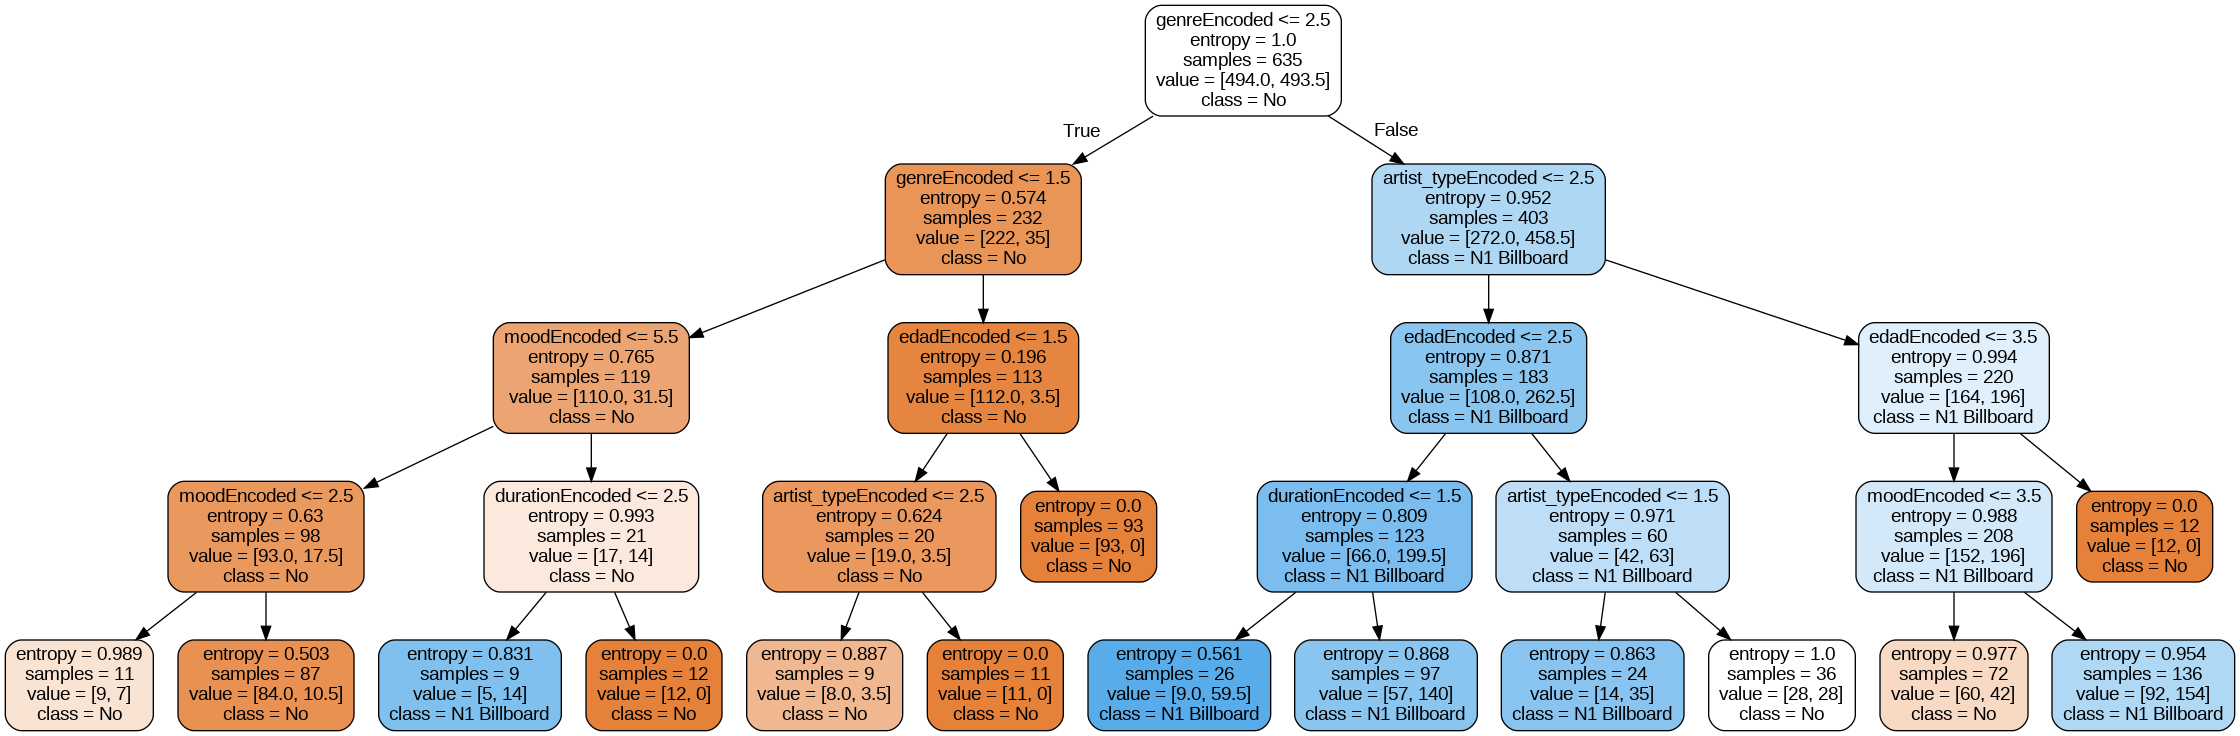

In [ ]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

Al fin nuestro preciado árbol aparece en pantalla!. Ahora tendremos que mirar y ver si lo podemos mejorar (por ejemplo tuneando los parámetros de entrada).

## Conclusiones

En la gráfica vemos, un nodo raíz que hace una primer subdivisión por género y las salidas van a izquierda por True que sea menor a 2.5, es decir los géneros 0, 1 y 2 (eran los que menos top=1 tenían) y a derecha en False van los géneros 3 y 4 que eran Pop y Urban con gran cantidad de usuarios top Billboard.

En el segundo nivel vemos que la cantidad de muestras (samples) queda repartida en 232 y 403 respectivamente.

A medida que bajamos de nivel veremos que los valores de entropía se aproximan más a 1 cuando el nodo tiene más muestras top=1 (azul) y se acercan a 0 cuando hay mayoría de muestras Top=0 (naranja).

En los diversos niveles veremos divisiones por tipo de artista , edad, duración y mood. También vemos algunas hojas naranjas que finalizan antes de llegar al último nivel: esto es porque alcanzan un nivel de entropía cero, o porque quedan con una cantidad de muestras menor a nuestro mínimo permitido para hacer split (20).

Veamos cuál fue la precisión alcanzada por nuestro árbol:

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

68.03


Nos da un valor de 68.03%. Notamos en que casi todas las hojas finales del árbol tienen samples mezclados sobre todo en los de salida para clasificar los top=1. Esto hace que se reduzca el score.

##Predicción de Canciones al Billboard 100

Vamos a probar nuestro árbol con 2 artistas que entraron al billboard 100 en 2017: Camila Cabello que llegó al numero 1 con la Canción Havana y Imagine Dragons con su canción Believer que alcanzó un puesto 42 pero no llegó a la cima.



In [ ]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
acc=y_proba[0][y_pred]* 100
accStr=str(np.round(acc[0],2))
print("Probabilidad de Acierto: " + accStr+"%")

Prediccion: [1]
Probabilidad de Acierto: 71.07%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Nos da que Havana llegará al top 1 con una probabilidad del 83%. Nada mal…

In [ ]:
#predecir artista Imagine Dragons
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
#print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred]* 100, 2))+"%")
acc2=y_proba[0][y_pred]* 100
accStr2=str(np.round(acc2[0],2))
print("Probabilidad de Acierto: " + accStr2+"%")

Prediccion: [0]
Probabilidad de Acierto: 88.89%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Nos da que la canción de Imagine Dragons NO llegará con una certeza del 88%. Otro acierto.

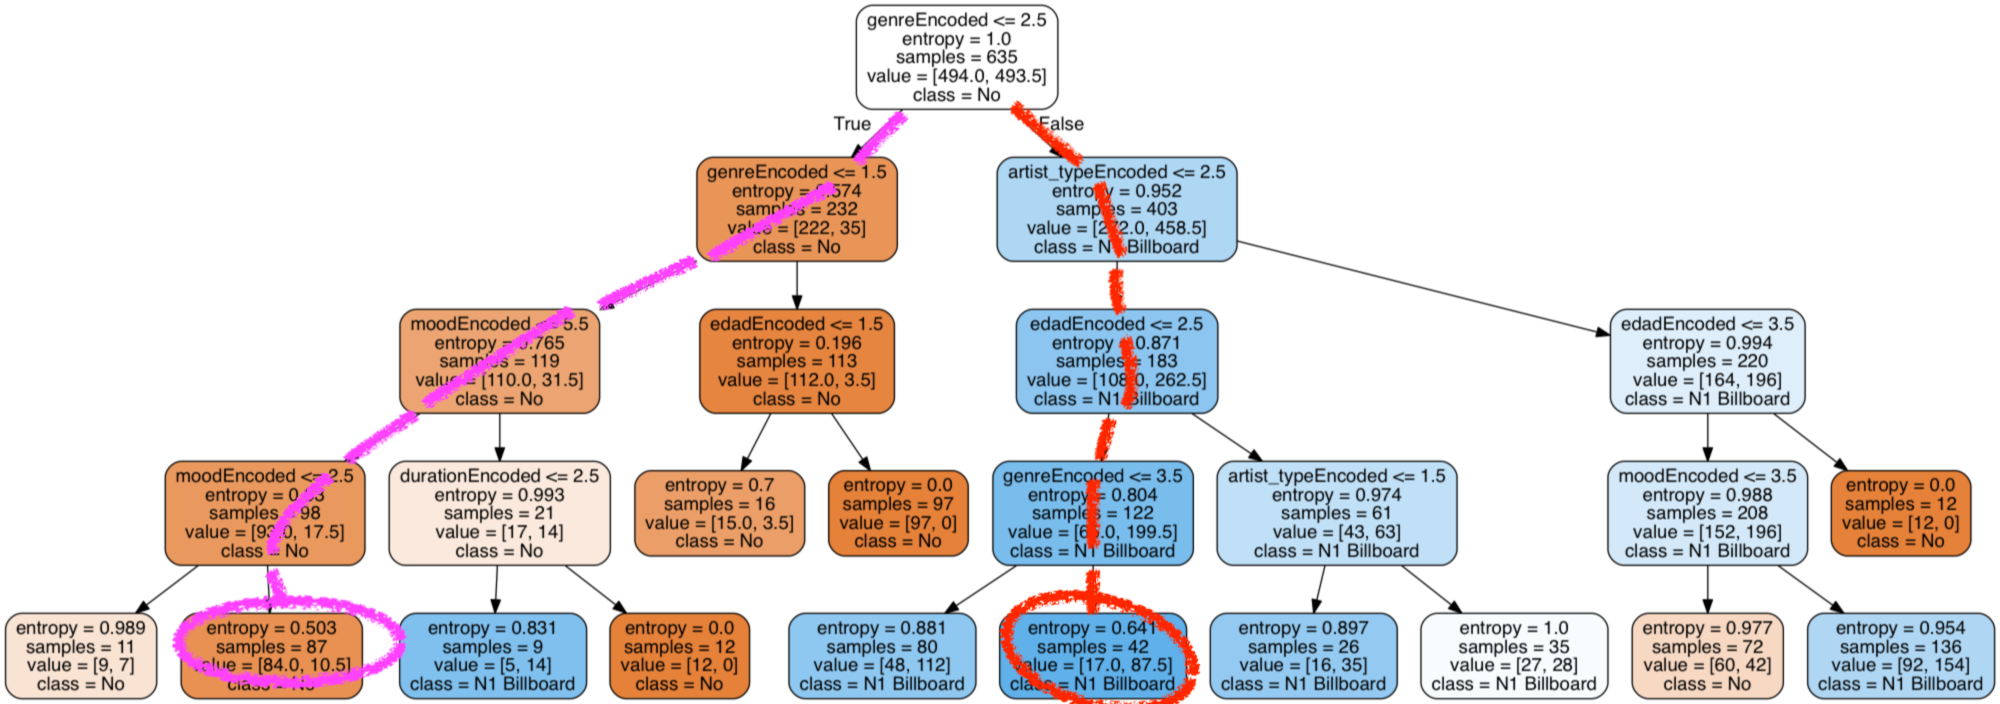

Aqui vemos los caminos tomados por Havana en Rojo, que alcanzó el número 1 y el camino por Believer (en rosa) que no llegó